In [1]:
!pip install umap-learn hdbscan tensorflow seaborn

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import umap
import hdbscan
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df=pd.read_csv("/content/bank_marketing_Data.csv")

In [4]:
df.head()

,spending,advance_payments,probability_of_full_payment,current_balance,credit_limit,min_payment_amt,max_spent_in_single_shopping
0,19.94,16.92,0.8752,6.675,3.763,3.252,6.550
1,15.99,14.89,0.9064,5.363,3.582,3.336,5.144
2,18.95,16.42,0.8829,6.248,3.755,3.368,6.148
3,10.83,12.96,0.8099,5.278,2.641,5.182,5.185
4,17.99,15.86,0.8992,5.890,3.694,2.068,5.837


In [5]:
df['balance_utilization'] = df['current_balance'] / (df['credit_limit'] + 1e-5)

In [6]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
df_clean = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

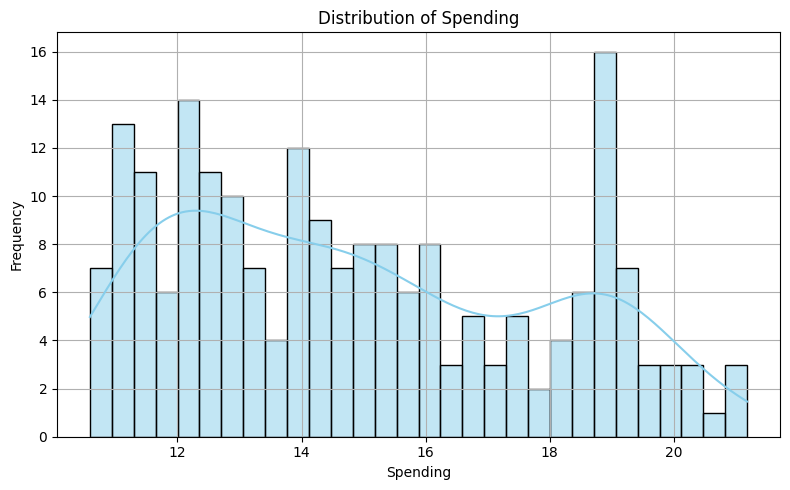

In [9]:

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


plt.figure(figsize=(8, 5))
sns.histplot(df_clean['spending'], bins=30, kde=True, color='skyblue')
plt.title("Distribution of Spending")
plt.xlabel("Spending")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()


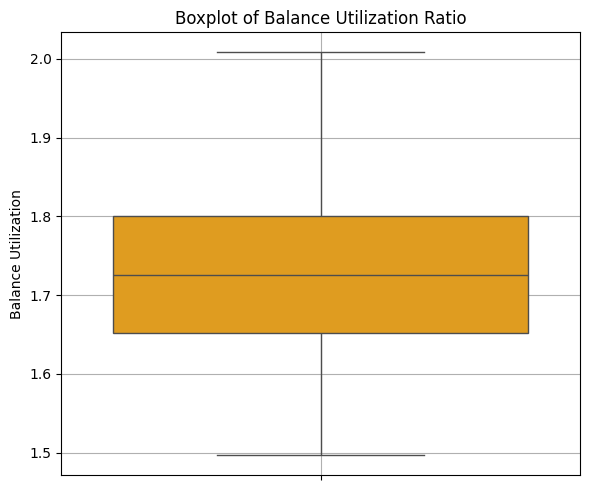

In [10]:

plt.figure(figsize=(6, 5))
sns.boxplot(y=df_clean['balance_utilization'], color='orange')
plt.title("Boxplot of Balance Utilization Ratio")
plt.ylabel("Balance Utilization")
plt.grid(True)
plt.tight_layout()
plt.show()



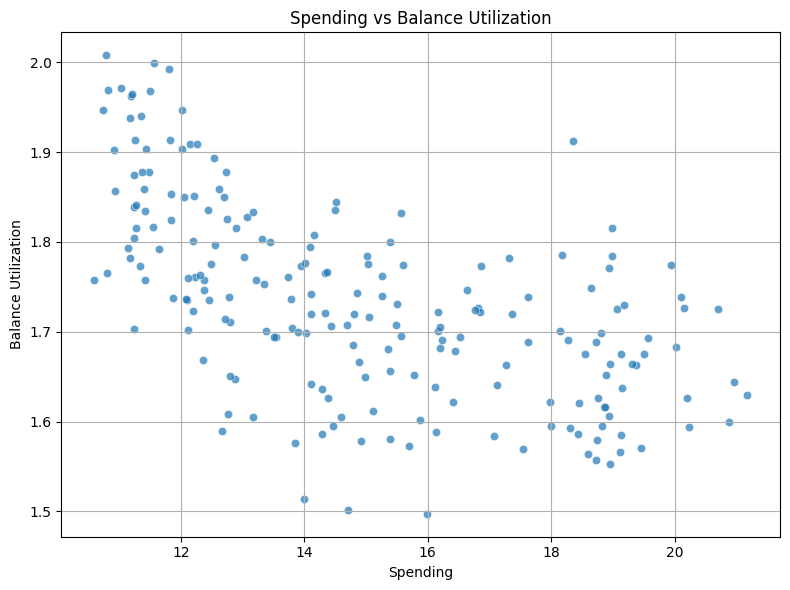

In [11]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='spending', y='balance_utilization', data=df_clean, alpha=0.7)
plt.title("Spending vs Balance Utilization")
plt.xlabel("Spending")
plt.ylabel("Balance Utilization")
plt.grid(True)
plt.tight_layout()
plt.show()

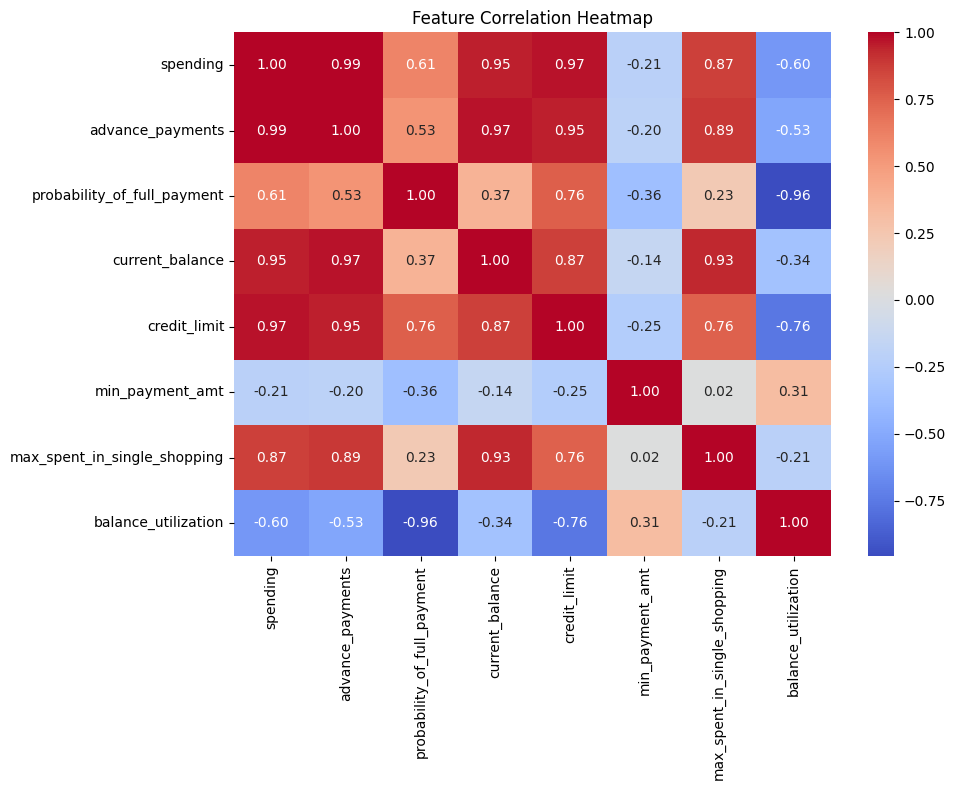

In [12]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_clean.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()

In [13]:
X_scaled = StandardScaler().fit_transform(df_clean)
sse = []
k_range = range(2, 11)
for k in k_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    sse.append(km.inertia_)

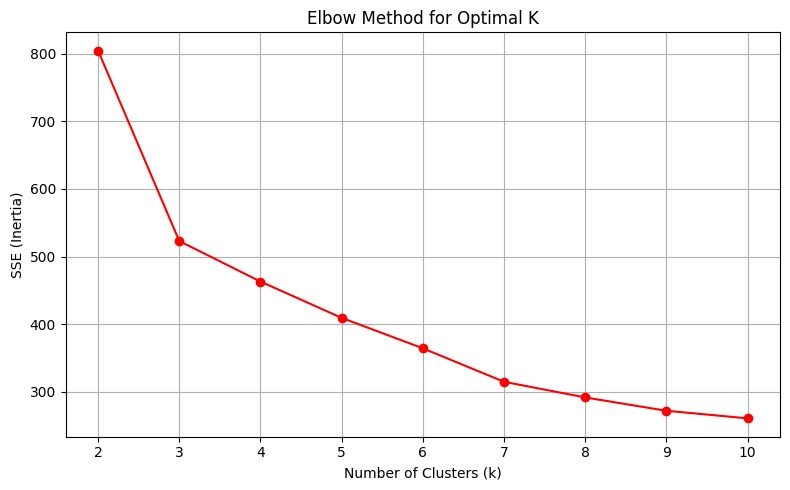

In [14]:
plt.figure(figsize=(8, 5))
plt.plot(k_range, sse, marker='o', color='red')
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("SSE (Inertia)")
plt.grid(True)
plt.tight_layout()
plt.show()

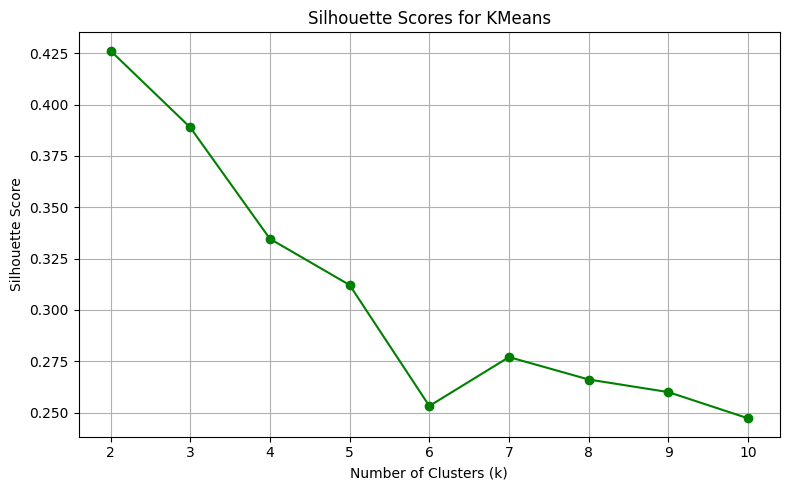

In [15]:
scores = []
for k in k_range:
    km = KMeans(n_clusters=k, random_state=42)
    labels_km = km.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels_km)
    scores.append(score)

plt.figure(figsize=(8, 5))
plt.plot(k_range, scores, marker='o', color='green')
plt.title("Silhouette Scores for KMeans")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_clean)

In [17]:
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

In [18]:
def build_autoencoder(input_dim, encoding_dim=5):
    input_layer = Input(shape=(input_dim,))
    x = Dense(32, activation='relu')(input_layer)
    x = BatchNormalization()(x)
    x = Dense(16, activation='relu')(x)
    x = Dropout(0.2)(x)
    encoded = Dense(encoding_dim, activation='relu')(x)

    x = Dense(16, activation='relu')(encoded)
    x = BatchNormalization()(x)
    decoded = Dense(input_dim, activation='linear')(x)

    autoencoder = Model(inputs=input_layer, outputs=decoded)
    encoder = Model(inputs=input_layer, outputs=encoded)
    autoencoder.compile(optimizer='adam', loss='mse')

    return autoencoder, encoder

autoencoder, encoder = build_autoencoder(X_pca.shape[1])
X_train, X_val = train_test_split(X_pca, test_size=0.2, random_state=42)

autoencoder.fit(X_train, X_train, validation_data=(X_val, X_val),
                epochs=100, batch_size=32,
                callbacks=[EarlyStopping(patience=10)], verbose=1)

encoded_data = encoder.predict(X_pca)

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 3.1321 - val_loss: 2.2829
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.7800 - val_loss: 2.2523
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.6231 - val_loss: 2.2102
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.2884 - val_loss: 2.1712
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 2.2455 - val_loss: 2.1318
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 2.2179 - val_loss: 2.0941
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.9317 - val_loss: 2.0531
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.8728 - val_loss: 2.0111
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.8269 - val_loss: 1.9765
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.6599 - val_loss: 1.9429
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.6321 - val_loss: 1.9102
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.4857 - val_lo

In [19]:
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
embedding = reducer.fit_transform(encoded_data)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [20]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=10)
labels = clusterer.fit_predict(embedding)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [21]:
mask = labels != -1
score = silhouette_score(embedding[mask], labels[mask]) if len(set(labels[mask])) > 1 else -1
print(f"\nSilhouette Score (excluding noise): {round(score, 4)}")



Silhouette Score (excluding noise): 0.7271999716758728


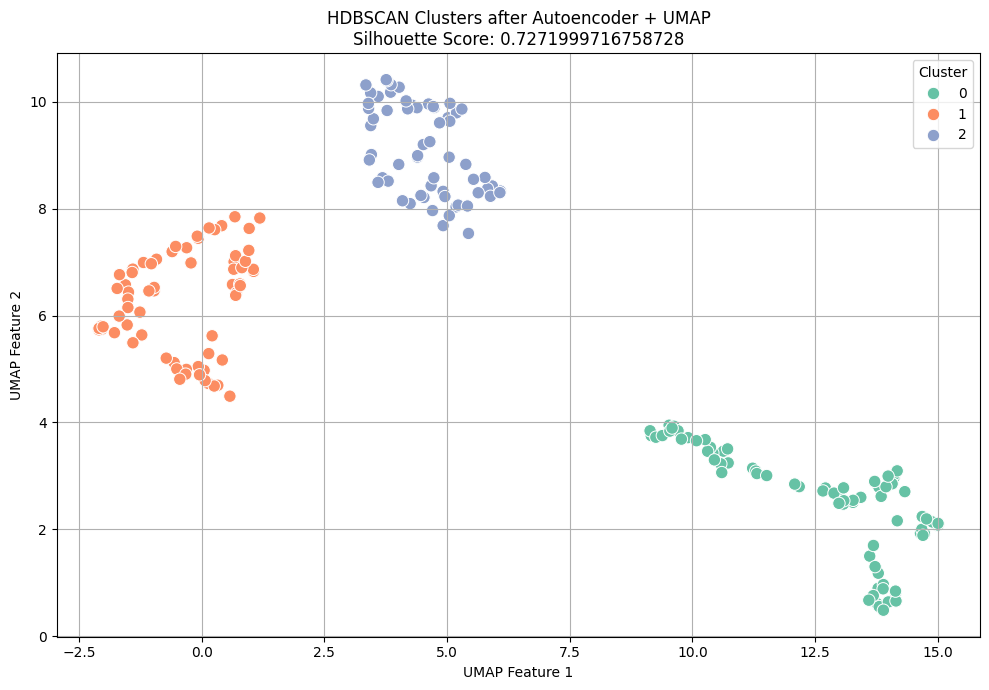

In [22]:
plt.figure(figsize=(10, 7))
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=labels, palette='Set2', s=80)
plt.title(f'HDBSCAN Clusters after Autoencoder + UMAP\nSilhouette Score: {round(score, 4)}')
plt.xlabel('UMAP Feature 1')
plt.ylabel('UMAP Feature 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()

In [23]:
cluster_counts = pd.Series(labels).value_counts().sort_index()
print("\nCustomer Count by Cluster:")
print(cluster_counts)


Customer Count by Cluster:
0    76
1    68
2    61
Name: count, dtype: int64
